In [4]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
from glob import glob
import matplotlib.pyplot as plt

working_path = "./"
orig_images_file_list = glob(working_path+"luna_images/*.npy")

./luna_images/images_0001_0036.npy


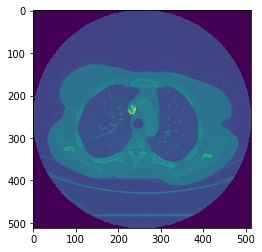

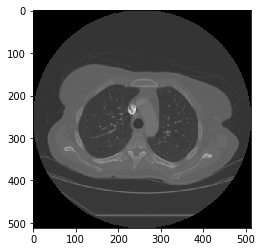

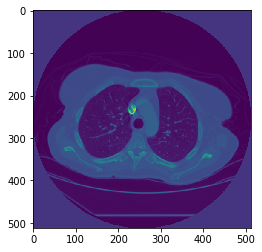

In [5]:
# View first image #
file = orig_images_file_list[0]
print file

imgs_to_process = np.load(file).astype(np.float64)
img = imgs_to_process[0]
plt.imshow(img)
plt.show()

mean = np.mean(img)
std = np.std(img) + .0000000001
img = img-mean
img = img/std
plt.imshow(img, cmap='gray')
plt.show()

middle = img[100:400,100:400] 
mean = np.mean(middle)  
max = np.max(img)
min = np.min(img)
# To improve threshold finding, I'm moving the 
# underflow and overflow on the pixel spectrum
img[img==max]=mean
img[img==min]=mean
plt.imshow(img)
plt.show()

In [ ]:
for img_file in orig_images_file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64)
    
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        
        #Standardize the pixel values
        mean = np.mean(img)
        std = np.std(img) + .0000000001
        img = img-mean
        img = img/std
        
        # Find the average pixel value near the lungs
        # to renormalize washed out images
        middle = img[100:400,100:400] 
        mean = np.mean(middle)  
        max = np.max(img)
        min = np.min(img)
        
        # To improve threshold finding, I'm moving the 
        # underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean
        
        # Using Kmeans to separate foreground (radio-opaque tissue)
        # and background (radio transparent tissue ie lungs)
        # Doing this only on the center of the image to avoid 
        # the non-tissue parts of the image as much as possible
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
        
        # I found an initial erosion helful for removing graininess from some of the regions
        # and then large dialation is used to make the lung region 
        # engulf the vessels and incursions into the lung cavity by 
        # radio opaque tissue
        eroded = morphology.erosion(thresh_img,np.ones([4,4]))
        dilation = morphology.dilation(eroded,np.ones([10,10]))
        
        #  Label each region and obtain the region properties.
        #  The background region is removed by removing regions 
        #  with a bbox that is too large in either dimension
        #  Also, the lungs are generally far away from the top 
        #  and bottom of the image, so any regions that are too
        #  close to the top and bottom are removed
        #  This does not produce a perfect segmentation of the lungs
        #  from the image, but it is surprisingly good considering its
        #  simplicity.
        labels = measure.label(dilation)
        label_vals = np.unique(labels)
        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
                good_labels.append(prop.label)
        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        
        #  The mask here is the mask for the lungs--not the nodes
        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask
        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
        imgs_to_process[i] = mask
        
    np.save('./luna_images/new_mask_' + img_file.split('/')[-1], imgs_to_process)

(0L, 0L, 512L, 512L)
(170L, 102L, 350L, 262L)
(176L, 263L, 359L, 390L)
(0L, 0L, 512L, 512L)
(172L, 105L, 349L, 261L)
(178L, 263L, 357L, 389L)
(0L, 0L, 512L, 512L)
(175L, 107L, 348L, 261L)
(180L, 262L, 355L, 388L)
(0L, 0L, 512L, 512L)
(154L, 93L, 357L, 267L)
(159L, 265L, 369L, 402L)
(0L, 0L, 512L, 512L)
(160L, 96L, 356L, 265L)
(162L, 265L, 368L, 400L)
(0L, 0L, 512L, 512L)
(162L, 97L, 355L, 261L)
(164L, 265L, 366L, 399L)
(254L, 226L, 282L, 264L)
(0L, 0L, 512L, 512L)
(178L, 110L, 346L, 261L)
(183L, 261L, 353L, 386L)
(0L, 0L, 512L, 512L)
(181L, 113L, 344L, 262L)
(187L, 261L, 351L, 385L)
(0L, 0L, 512L, 512L)
(185L, 115L, 341L, 262L)
(194L, 261L, 348L, 382L)
(0L, 0L, 512L, 512L)
(136L, 73L, 376L, 267L)
(145L, 266L, 385L, 428L)
(0L, 0L, 512L, 512L)
(135L, 73L, 375L, 268L)
(144L, 266L, 384L, 426L)
(0L, 0L, 512L, 512L)
(135L, 73L, 373L, 269L)
(144L, 266L, 383L, 425L)
(0L, 0L, 512L, 512L)
(134L, 67L, 379L, 261L)
(150L, 268L, 388L, 433L)
(0L, 0L, 512L, 512L)
(136L, 67L, 378L, 261L)
(149L, 268L, 3

In [ ]:
# Here we're applying the masks and cropping and resizing the image

masks_file_list = glob(working_path+"luna_images/new_mask_*.npy")
print(len(masks_file_list))

out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in masks_file_list:
    print "working on file ", fname
    imgs_to_process = np.load(fname.replace("masks","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        print(mask[mask!=0])
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        print("Labels?: ", labels[labels!=0])
        print("Regions: ", regions)
        #
        # Finding the global min and max row over all regions
        #
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img  = img[min_row:max_row,min_col:max_col]
        mask = mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            print("no good regions")
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img,[512,512])
            new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
            out_images.append(new_img)
            out_nodemasks.append(new_node_mask)

In [29]:
num_images = len(out_images)
print(num_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(working_path+"testMasks.npy",final_masks[rand_i[:test_i]])

216
